In [2]:
#Importamos bibliotecas
import pandas as pd
import numpy as np
from matplotlib import pyplot as plot
import seaborn as sns
import datetime as dt

# 1. Importación y Preparación del Dataset

In [3]:
data = pd.read_excel(r"./demandaHistoricaSadi.xlsx")
data = data.drop(['AÑO', 'MES', 'N° MES', 'SEMANA', 'N° DIA', 'Hora Potencia Pico'], axis=1)
data = data.set_index('FECHA')
# data = data.reindex(columns=['Energía SADI (GWh)', 'Potencia Pico SADI (MW)', 'DIA', 'TIPO DIA', 'VERANO / INVIERNO', 'Temperatura Media Diaria GBA (°C)', 'Estado del Tiempo [Claro/Nublado/Seminublado]'])
data.columns = ['VERANO / INVIERNO', 'TIPO DIA', 'DIA', 'Energía SADI (GWh)', 'Potencia Pico SADI (MW)', 'T Media GBA (°C)', 'Claro/Nublado/Seminublado']
data = data.reindex(columns=['Energía SADI (GWh)', 'Potencia Pico SADI (MW)', 'DIA', 'TIPO DIA', 'VERANO / INVIERNO', 'T Media GBA (°C)', 'Claro/Nublado/Seminublado'])
data.to_excel(r"../modelo_predictivo/demandaHistorica.xlsx")
data

,Energía SADI (GWh),Potencia Pico SADI (MW),DIA,TIPO DIA,VERANO / INVIERNO,T Media GBA (°C),Claro/Nublado/Seminublado
FECHA,,,,,,,
2007-01-01,277.581153,14157.0,Lunes,FERIADO,VERANO,29.2,C
2007-01-02,325.393852,15801.0,Martes,HÁBIL,VERANO,26.01,N
2007-01-03,325.492540,16136.0,Miércoles,HÁBIL,VERANO,25,N
2007-01-04,334.033576,16782.0,Jueves,HÁBIL,VERANO,25,N
2007-01-05,320.328528,15321.0,Viernes,HÁBIL,VERANO,22.6,C
...,...,...,...,...,...,...,...
2023-06-07,399.412437,19646.0,Miércoles,HÁBIL,INVIERNO,18.4,N
2023-06-08,391.938465,19004.0,Jueves,HÁBIL,INVIERNO,21.8,N
2023-06-09,391.815378,19758.0,Viernes,HÁBIL,INVIERNO,18,N


In [49]:
# Verificamos que la serie de tiempo esté completa

(data.index == pd.date_range(start=data.index.min(),
                              end=data.index.max(),
                              freq=data.index.freq)).all()

True

In [50]:
# Verificamos que no tenga nulos

print(f"Número de filas con nulos: {data.isnull().any(axis=1).mean()}")

Número de filas con nulos: 0.0


## 2. Exploración gráfica

##### 2.1 Gráfico de la serie temporal completa

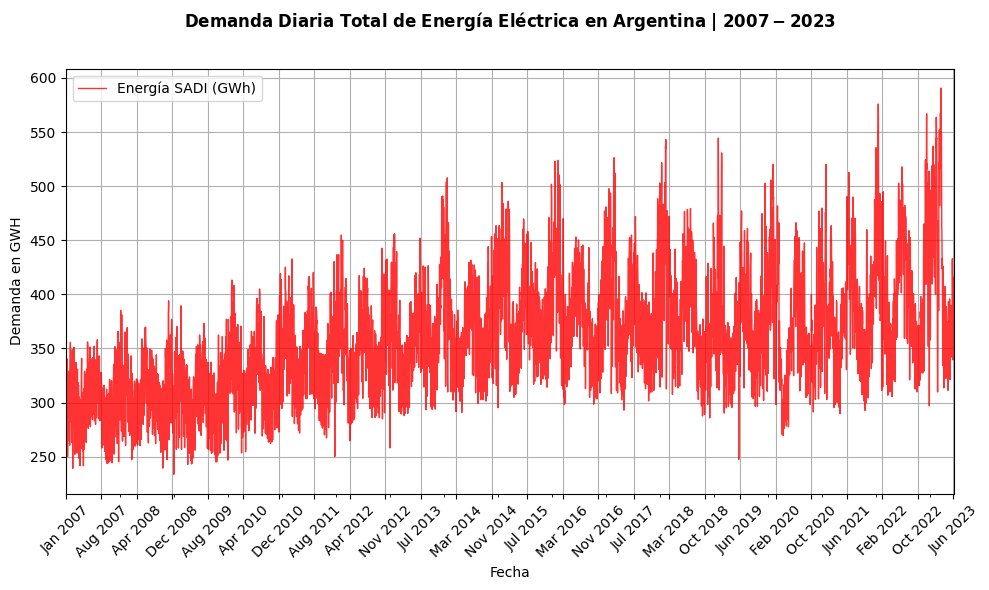

In [96]:
fig, ax = plot.subplots(figsize=(10, 6))
data['Energía SADI (GWh)'].plot(ax=ax, label='Energía SADI (GWh)', linewidth=1, color='red', alpha=0.8)
# Personalizar el gráfico
plot.title(r'$\mathbf{Demanda\ Diaria\ Total\ de\ Energía\ Eléctrica\ en\ Argentina\ | \ 2007-2023}$', pad=30)
plot.xlabel('Fecha')
plot.ylabel('Demanda en GWH')
plot.grid(True)

# Configurar el intervalo de las etiquetas del eje x (por ejemplo, cada año)
plot.xticks(data.index[::240], data.index.strftime('%b %Y')[::240], rotation=45)

# Mostrar una leyenda
plot.legend()

# Mostrar el gráfico
plot.tight_layout()  # Para ajustar el diseño y evitar cortes en etiquetas
plot.show()

##### 2.2 Gráfico de la serie temporal por sección arbitraria

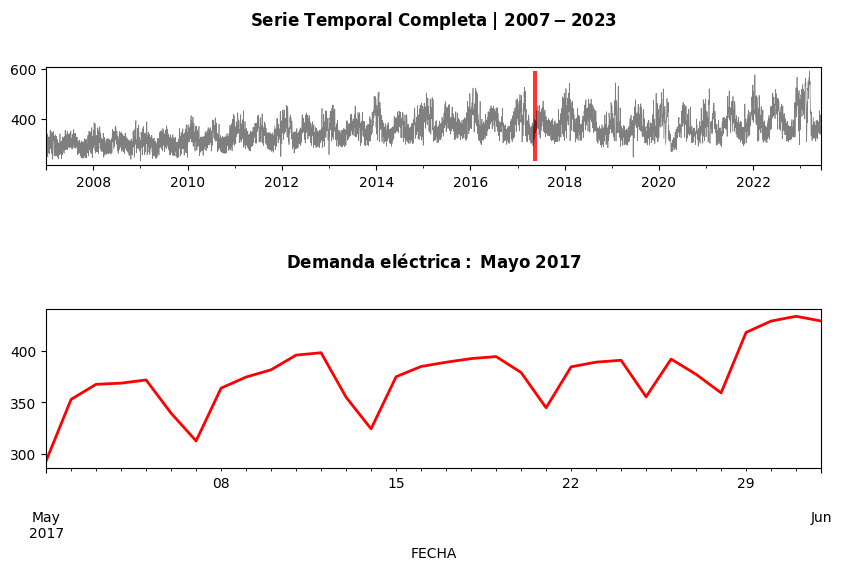

In [132]:
zoom = ('2017-05-01','2017-06-01')
fig = plot.figure(figsize=(10, 6))
grid = plot.GridSpec(nrows=8, ncols=1, hspace=0.6, wspace=0)
main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[5:, :])
data['Energía SADI (GWh)'].plot(ax=main_ax, c='black', alpha=0.5, linewidth=0.5)
min_y = min(data['Energía SADI (GWh)'])
max_y = max(data['Energía SADI (GWh)'])
main_ax.fill_between(zoom, min_y, max_y, facecolor='red', alpha=0.8, zorder=0)
main_ax.set_xlabel('')
data.loc[zoom[0]: zoom[1]]['Energía SADI (GWh)'].plot(ax=zoom_ax, color='red', linewidth=2)
main_ax.set_title(r'$\mathbf{Serie\ Temporal\ Completa\ | \ 2007-2023}$', pad=30)
zoom_ax.set_title(r'$\mathbf{Demanda\ eléctrica:\ Mayo \ 2017}$', pad=30)
plot.subplots_adjust(hspace=1)

##### 2.2 Análisis de estacionalidad

###### 2.2.1 Estacionalidad Mensual

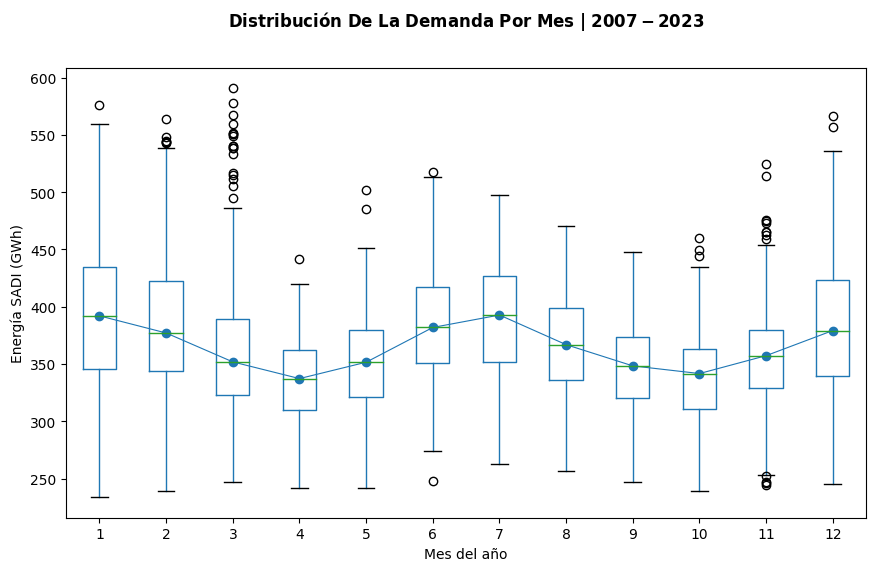

In [131]:
fig, ax = plot.subplots(figsize=(10, 6))
data['mes'] = data.index.month
data.boxplot(column='Energía SADI (GWh)', by='mes', ax=ax,)
data.groupby('mes')['Energía SADI (GWh)'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Energía SADI (GWh)')
ax.set_xlabel('Mes del año')
ax.set_title(r'$\mathbf{Distribución\ De\ La\ Demanda \ Por \ Mes\ | \ 2007-2023}$', pad=30)
fig.suptitle('');

###### 2.2.1 Estacionalidad Por Día de la Semana

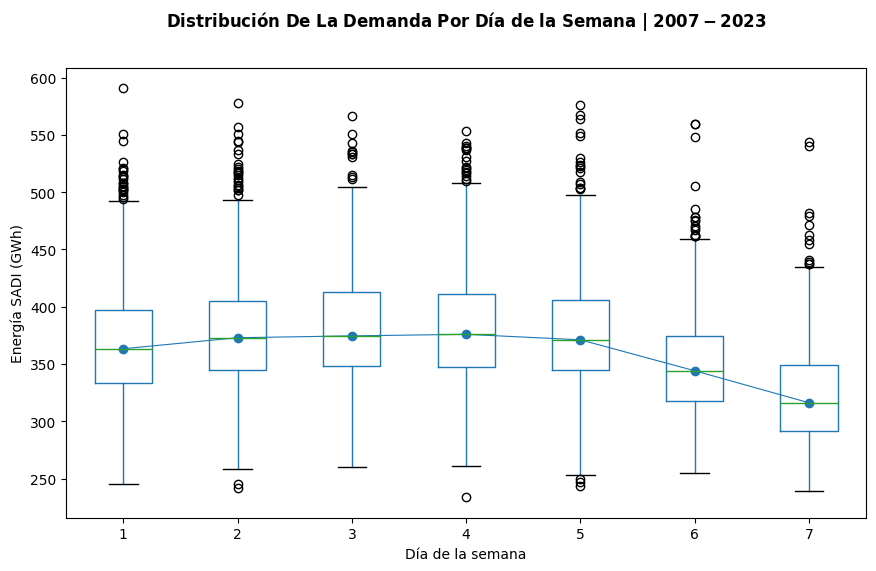

In [130]:
fig, ax = plot.subplots(figsize=(10, 6))
data['dia_semana'] = data.index.day_of_week + 1
data.boxplot(column='Energía SADI (GWh)', by='dia_semana', ax=ax)
data.groupby('dia_semana')['Energía SADI (GWh)'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Energía SADI (GWh)')
ax.set_title(r'$\mathbf{Distribución\ De\ La\ Demanda \ Por \ Día \ de \ la \ Semana\ | \ 2007-2023}$', pad=30)
ax.set_xlabel('Día de la semana')
fig.suptitle('');

###### 2.2.1 Estacionalidad Por Tipo de Día

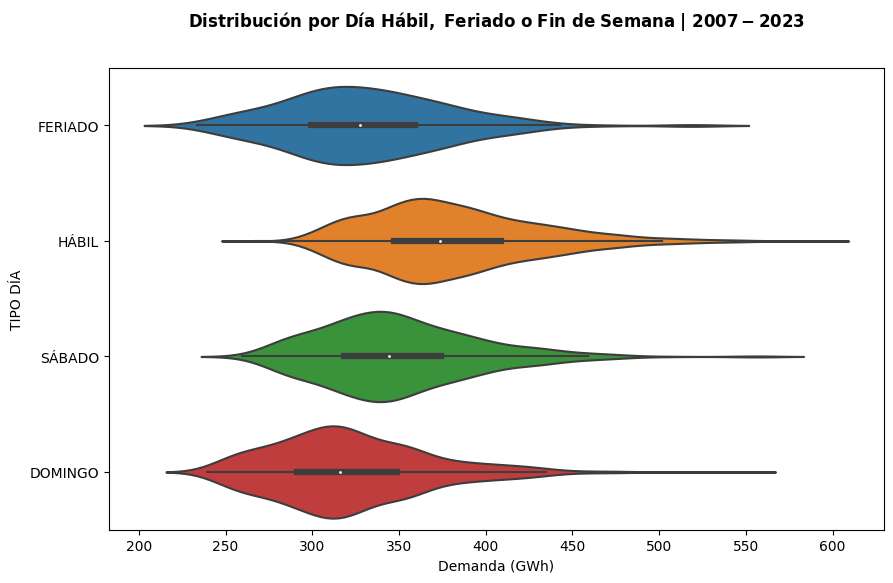

In [129]:
fig, ax = plot.subplots(figsize=(10, 6))
sns.violinplot(
    x       = 'Energía SADI (GWh)',
    y       = 'TIPO DIA',
    data    = data.assign(Holiday = data['TIPO DIA'].astype(str)),
    ax      = ax
)
ax.set_title(r'$\mathbf{Distribución\ por\ Día\ Hábil, \ Feriado \ o  \ Fin \ de \ Semana\ | \ 2007-2023}$', pad=30)
ax.set_xlabel('Demanda (GWh)')
ax.set_ylabel('TIPO DÍA');

###### 2.2.1 Estacionalidad Por Invierno o Verano

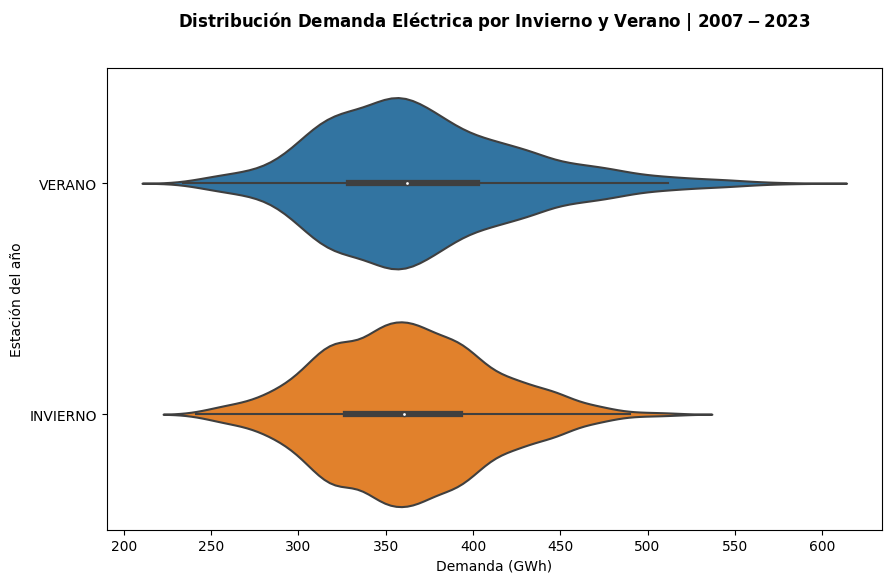

In [128]:
fig, ax = plot.subplots(figsize=(10, 6))
sns.violinplot(
    x       = 'Energía SADI (GWh)',
    y       = 'VERANO / INVIERNO',
    data    = data.assign(Holiday = data['VERANO / INVIERNO'].astype(str)),
    ax      = ax
)
ax.set_title(r'$\mathbf{Distribución\ Demanda \ Eléctrica \ por\ Invierno\ y \ Verano \ | \ 2007-2023 }$', pad=30)
ax.set_xlabel('Demanda (GWh)')
ax.set_ylabel('Estación del año');